# *编程作业三*  
课本P26

## 站点信息  
sta. XM       
Lat:24deg. 27min. N 
Lon:118deg. 40min. E  
units: mm
time: 1996-12-27~1997-12-31 (GMT)
missvaule: 9999

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from datetime import datetime
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter

## 原始数据读取&处理

### 数据读取

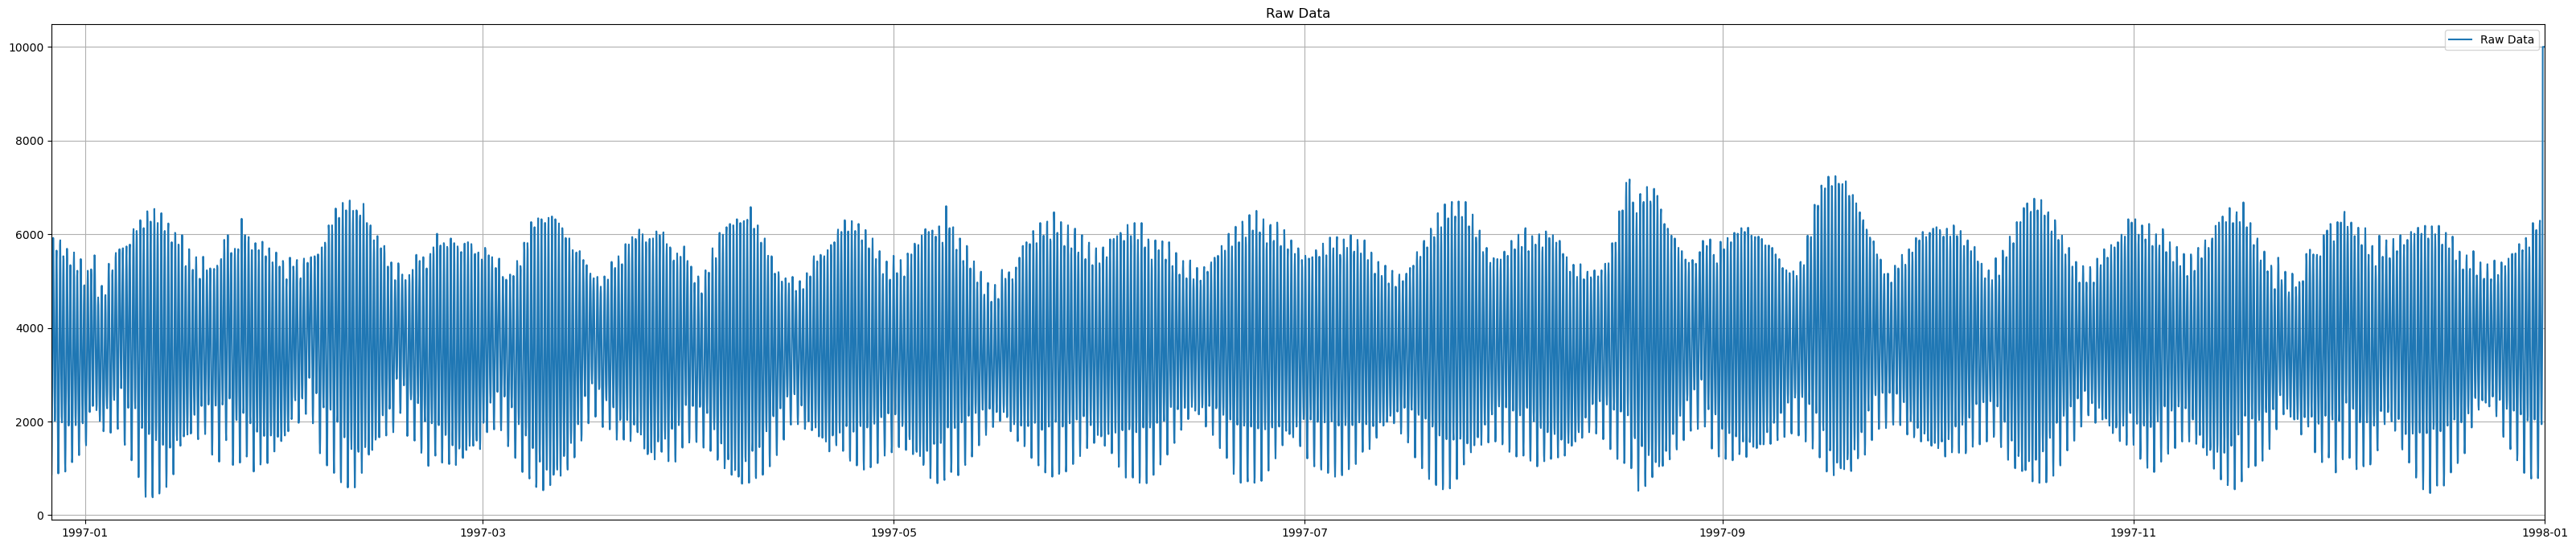

In [3]:
# 数据读取
datas=[]
dates=[]
for i in open('xm-370d.txt').readlines()[6:]:
    sp=i.split()
    #print(sp)
    for i in range(24):
        dates.append(f'{sp[0][:4]}{sp[0][4:6]}{sp[0][6:8]} {i:0>2}:00')
    datas.extend(sp[1:])
datas=np.array(list(map(float,datas)))
dates=pd.to_datetime(np.unique(dates))+pd.Timedelta(hours=1)
del sp,i
# 可视化
plt.figure(figsize=[40,8])
plt.plot(dates,datas,label='Raw Data')
plt.title('Raw Data')
plt.xlim(dates[0],dates[-1]);plt.legend();plt.grid();plt.show()

### 异常值处理
From Work1

#### 统计特性检验

In [4]:

def GetReindaAno(d):
  """
  返回数据值根据莱因达准则计算的异常值的逻辑索引
  Parameters:
    d - 原始数据
  Returns:
  	异常值的逻辑索引
  """
  return (np.abs(d-np.mean(d))-3*np.std(d)>=0)

d=pd.DataFrame(
  index=np.array(dates[GetReindaAno(datas)==True]),
  columns=['异常值','异常数组索引位置'],
  data=np.array([datas[GetReindaAno(datas)==True],np.where(GetReindaAno(datas)==True)[0]],dtype=int).T
  )
d.index.name='异常时间'
print(f'数组总长度：{datas.shape[0]}')
# print(f'异常数组索引位置：{np.where(GetReindaAno(datas)==True)[0]}')
# print(f'异常值：{datas[GetReindaAno(datas)==True]}')
# print(f'异常时间：{np.array(dates[GetReindaAno(datas)==True].strftime("%Y-%m-%d %H:00"))}')
display(d)
d.to_csv('demo.csv',encoding='utf-8')
dates=dates[~GetReindaAno(datas)]
datas=datas[~GetReindaAno(datas)]
datas=datas[:-1];dates=dates[:-1] # 使数据长度为奇数
#del d

数组总长度：8880


,异常值,异常数组索引位置
异常时间,,
1997-12-31 17:00:00,9999,8872
1997-12-31 18:00:00,9999,8873
1997-12-31 19:00:00,9999,8874
1997-12-31 20:00:00,9999,8875
1997-12-31 21:00:00,9999,8876
1997-12-31 22:00:00,9999,8877
1997-12-31 23:00:00,9999,8878
1998-01-01 00:00:00,9999,8879


#### 连续性检验

In [5]:
k=datas[1:]-datas[:-1]
print(f'数组长度：{k.shape[0]}')
print(f'异常数组索引位置：{np.where(GetReindaAno(k)==True)[0]}')
print(f'异常值：{k[GetReindaAno(k)==True]}')
if np.sum(GetReindaAno(k))==0:print('无异常')
del k

数组长度：8870
异常数组索引位置：[]
异常值：[]
无异常


## 计算

### 计算各分潮的角速率$\sigma$和初相位角$V_0$

In [6]:
# 常数生成与计算
def sin_pi(x):
    return np.sin(x*np.pi/180)
def cos_pi(x):
    return np.cos(x*np.pi/180)
def jd(v):
  return v%360
def doodson(name):
    """
    返回数据值根据莱因达准则计算的异常值的逻辑索引
    Parameters:
      name - 分潮名
    Returns:
    	分潮的Doodson数
    """
    if   name.upper()=="M2" :return np.array([2 ,0 ,0 ,0 ,0 ,0 ])
    elif name.upper()=="O1" :return np.array([1 ,-1,0 ,0 ,0 ,0 ])
    elif name.upper()=="S2" :return np.array([2 ,2 ,-2,0 ,0 ,0 ])
    elif name.upper()=="K1" :return np.array([1 ,1 ,0 ,0 ,0 ,0 ])
    elif name.upper()=="P1" :return np.array([1 ,1 ,-2,0 ,0 ,0 ])
    elif name.upper()=="N2" :return np.array([2 ,-1,0 ,1 ,0 ,0 ])
    elif name.upper()=="Q1" :return np.array([1 ,-2,0 ,1 ,0 ,0 ])
    elif name.upper()=="K2" :return np.array([2 ,2 ,0 ,0 ,0 ,0 ])
    elif name.upper()=="M4" :return np.array([4 ,0 ,0 ,0 ,0 ,0 ])
    elif name.upper()=="MS4":return np.array([4 ,2 ,-2,0 ,0 ,0 ])
    else: raise ValueError(f'分潮数据{name.upper()}未记录')
  
def get_f(name,N):
    if   name.upper()=="M2" :return 1.0004-0.0373*cos_pi(N)+0.0003*cos_pi(2*N)
    elif name.upper()=="O1" :return 1.0089+0.1871*cos_pi(N)-0.0147*cos_pi(2*N)+0.0014*cos_pi(3*N)
    elif name.upper()=="S2" :return 1
    elif name.upper()=="K1" :return 1.0060+0.1150*cos_pi(N)-0.0088*cos_pi(2*N)+0.0006*cos_pi(3*N)
    elif name.upper()=="P1" :return 1
    elif name.upper()=="N2" :return get_f('M2',N)
    elif name.upper()=="Q1" :return get_f('O1',N)
    elif name.upper()=="K2" :return 1.0241+0.2863*cos_pi(N)+0.0083*cos_pi(2*N)-0.0015*cos_pi(3*N)
    elif name.upper()=="M4" :return get_f('M2',N)**2
    elif name.upper()=="MS4":return get_f('M2',N)**2
    else: raise ValueError(f'分潮数据{name.upper()}未记录')

def get_u(name,N):
    if   name.upper()=="M2" :return -2.14*sin_pi(N)
    elif name.upper()=="O1" :return 10.80*sin_pi(N)-1.34*sin_pi(2*N)+0.19*sin_pi(3*N)
    elif name.upper()=="S2" :return 0
    elif name.upper()=="K1" :return -8.86*sin_pi(N)+0.68*sin_pi(2*N)-0.07*sin_pi(3*N)
    elif name.upper()=="P1" :return 0
    elif name.upper()=="N2" :return get_u('M2',N)
    elif name.upper()=="Q1" :return get_u('O1',N)
    elif name.upper()=="K2" :return -17.74*sin_pi(N)+0.68*sin_pi(2*N)-0.04*sin_pi(3*N)
    elif name.upper()=="M4" :return get_u('M2',N)*2
    elif name.upper()=="MS4":return get_u('M2',N)
    else: raise ValueError(f'分潮数据{name.upper()}未记录')
    
def get_sigma_V(name,σ,V0,t):
    """
    根据常数计算分潮的相位角σ和初相位角V_0
    Parameters:
      name - 分潮名
      σ    - [σ_τ,σ_s,σ_h,σ_p,σ_N,σ_pdot]
      V0   - [τ_0,s_0,h_0,p_0,N_0,p_dot_0]
    Returns:
    	分潮的相位角σ和初相位角V_0
    """
    Doodson= doodson(name)
    σ_n =np.sum(Doodson*σ )-2*Doodson[4]* σ[4]
    V0_n=np.sum(Doodson*V0)-2*Doodson[4]*V0[4]
    return σ_n,V0_n+σ_n*t
  
def get4(name):
    """
    计算原始数据对应的天文常数
    Parameters:
      name - 分潮名
      datas- 数据
      dates- 时间
    Returns:
    	分潮的相位角σ和初相位角V_0
    """
    global datas,dates
    N=datas.shape[0] # 记录个数
    #Δt=1 # 时间间隔
    Middle_time=dates[int(N/2)] # 中间时刻
    #print(int(N/2))
    # Y=Middle_time.year
    # M=Middle_time.month
    # D=Middle_time.day

    #σ_T   =15
    σ_τ   =14.49205212
    σ_s   =0.54901653 
    σ_h   =0.04106864 
    σ_p   =0.00464183 
    σ_N   =0.00220641 
    σ_pdot=0.00000196 
    σ=np.array([σ_τ,σ_s,σ_h,σ_p,σ_N,σ_pdot])

    D=(
    datetime(year=Middle_time.year,month=Middle_time.month,day=Middle_time.day)-
    datetime(year=Middle_time.year,month=1,day=1)
    ).days
    y=Middle_time.year
    Y=int((y - 1901) / 4)
    t=Middle_time.hour

    T_0=180.
    s_0     =277.025+129.38481*(y-1900)+13.17640*(D+Y)
    h_0     =280.190-0.23872  *(y-1900)+0.98565 *(D+Y)
    p_0     =334.385+40.66249 *(y-1900)+0.11140 *(D+Y)
    N_0     =259.157-19.32818 *(y-1900)-0.05295 *(D+Y)
    p_dot_0 =281.221+0.01718  *(y-1900)+0.000047*(D+Y)
    τ_0=T_0-s_0+h_0
    V_0=np.array([τ_0,s_0,h_0,p_0,N_0,p_dot_0])
    #print(N_0)
    #print(Middle_time)
    #print(N_0)
    return [get_sigma_V(name,σ,V_0,t)[0],get_sigma_V(name,σ,V_0,t)[1],get_f(name,N_0),get_u(name,N_0)]
# get4('M2')

constituent=["M2","O1","S2","K1","P1","N2","Q1","K2","M4","MS4"]
df1=pd.DataFrame(
    index=constituent,
    data=np.array(list(map(get4,constituent))),
    columns=['σ','V_0','f_0','u_0'])
df1.index.name='分潮'
display(df1)

,σ,V_0,f_0,u_0
分潮,,,,
M2,28.984104,-29150.397235,1.037758,-0.239483
O1,13.943036,-30088.339718,0.807322,1.569357
S2,30.000000,960.000000,1.000000,0.000000
K1,15.041069,937.942483,0.882576,-1.165851
P1,14.958931,22.057517,1.000000,0.000000
N2,28.439730,-40362.184769,1.037758,-0.239483
Q1,13.398661,-41300.127252,0.807322,1.569357
K2,30.082137,1875.884966,0.749106,-2.149690
M4,57.968208,-58300.794470,1.076942,-0.478966


In [7]:
A=np.zeros(shape=(11,11))
B=np.zeros(shape=(10,10))
N=dates.shape[0] # 个数
Δt=1 # 时间间隔
σ=list(df1['σ'])

A[0,0]=N
for i in range(1,11):
    A[i,0]=sin_pi(N/2*σ[i-1]*Δt)/sin_pi(1/2*σ[i-1]*Δt)
for j in range(1,11):
    A[0,j]=sin_pi(N/2*σ[j-1]*Δt)/sin_pi(1/2*σ[j-1]*Δt)
for i in range(1,11):
    for j in range(1,11):
        if i==j:
            A[i,j]=1/2*(N+(sin_pi(N*σ[i-1]*Δt)/sin_pi(σ[i-1]*Δt)))
        elif i>j :
            # print(i,j)
            A[i,j]=1/2*(sin_pi(N/2*(σ[i-1]-σ[j-1])*Δt)/sin_pi(1/2*(σ[i-1]-σ[j-1])*Δt)+
                       sin_pi(N/2*(σ[i-1]+σ[j-1])*Δt)/sin_pi(1/2*(σ[i-1]+σ[j-1])*Δt))
            A[j,i]=A[i,j]
for i in range(0,10):
    for j in range(0,10):
        if i==j:
            # print(N,σ[i])
            B[i,j]=1/2*(N-(sin_pi(N*σ[i]*Δt)/sin_pi(σ[i]*Δt)))
        elif i>j :
            B[i,j]=1/2*(sin_pi(N/2*(σ[i]-σ[j])*Δt)/sin_pi(1/2*(σ[i]-σ[j])*Δt)-
                       sin_pi(N/2*(σ[i]+σ[j])*Δt)/sin_pi(1/2*(σ[i]+σ[j])*Δt))
            B[j,i]=B[i,j]
F1=np.zeros(shape=(11,1))
F2=np.zeros(shape=(10,1))
F1[0,0]=np.sum(datas)
n=np.arange(1,N+1,1)-int(N/2)-1
for i in range(1,11):
    F1[i,0]=np.sum(datas*cos_pi(n*σ[i-1]*Δt))
for j in range(0,10):
    F2[j,0]=np.sum(datas*sin_pi(n*σ[j]*Δt))
def getθ(θ):
    if θ<0:
        return getθ(θ+180)
    elif θ>360:
        return getθ(θ-180)
    else:
        return θ
S0=np.linalg.solve(A,F1)[0,0]
a=np.linalg.solve(A,F1)[1:,0]
b=np.linalg.solve(B,F2)[:,0]
n0=np.array([0,-1,0,1,-1,0,-1,0,0,0])
df2=pd.DataFrame(
    index=constituent,
    data=np.array([
        a,b,np.sqrt(a**2+b**2),np.arctan(b/np.array(list(map(getθ,np.linalg.solve(A,F1)[1:,0]))))/np.pi*180,np.sqrt(a**2+b**2)/np.array(df1['f_0'].values),
        np.array(list(map(jd,np.arctan(b/a)+df1['V_0'].values+df1['u_0'].values+n0*90)))
        ]).T,
    columns=['a','b','R','θ','H','g'])
df2.index.name='分潮'
del A,a,B,b,constituent,F1,F2,Δt,i,j,N
display(df2)

,a,b,R,θ,H,g
分潮,,,,,,
M2,-1460.102843,1239.338306,1915.165724,82.648415,1845.483605,8.659484
O1,-53.780013,-216.599202,223.175949,-59.769138,276.439846,64.557064
S2,368.429984,-377.902054,527.778946,-63.498182,527.778946,239.201911
K1,197.306115,228.400426,301.821898,49.177560,341.978206,307.634942
P1,51.051973,97.105078,109.707339,62.267323,109.707339,293.144287
N2,-349.550854,64.514394,355.454506,80.799918,342.521514,317.393238
Q1,13.719769,-43.172999,45.300551,-72.370479,56.112128,10.179002
K2,-51.515602,102.913995,115.087565,38.694182,153.633137,72.628583
M4,34.167625,-87.967445,94.370006,-68.773225,87.627747,17.526245


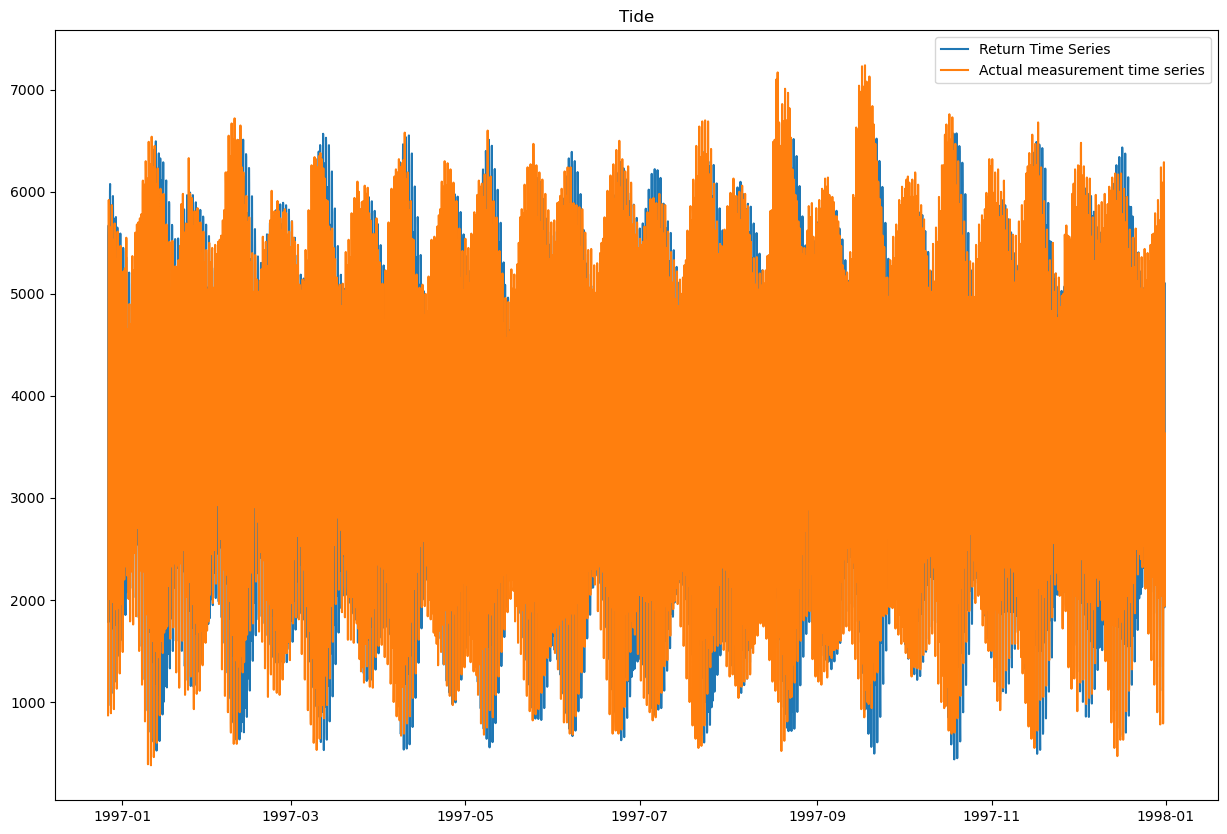

In [8]:
v_n=np.zeros(shape=n.shape)
for i in range(n.shape[0]):
    v_n[i]=S0+np.sum(df2['R'].values*cos_pi(np.array(σ)*n[i]-df2['θ'].values))
plt.figure(figsize=[15,10])
plt.plot(dates,v_n,label='Return Time Series')
plt.plot(dates,datas,label='Actual measurement time series')
plt.legend()
plt.title('Tide')
del i,n,n0,S0,σ
#plt.xlim(0,4000)

In [9]:
v_n_1978=v_n[dates.month==8]



# 寻找极值点
max_points = np.where(np.r_[True, v_n_1978[1:] > v_n_1978[:-1]] & np.r_[v_n_1978[:-1] > v_n_1978[1:], True])[0]
min_points = np.where(np.r_[True, v_n_1978[1:] < v_n_1978[:-1]] & np.r_[v_n_1978[:-1] < v_n_1978[1:], True])[0]
#
#df_hl=pd.DataFrame(columns=['高潮时间','高潮潮高','低潮时间','低潮潮高'],data=)
df_hl=pd.DataFrame(columns=['高潮时间'],data=dates[max_points])
df_hl['高潮潮高']=np.array([v_n_1978[max_points]]).T
df_hl['低潮时间']=np.array(dates[min_points]).T
df_hl['低潮潮高']=np.array([v_n_1978[min_points]]).T
df_hl['潮差']=np.array([v_n_1978[max_points]-v_n_1978[min_points]]).T

# df_low=pd.DataFrame(index=dates[min_points],columns=['潮高'],data=v_n_1978[min_points])
# df_high.index.name=
# df_low.index.name=
display(df_hl)
df_hl.to_csv('潮差.csv')
print(f'平均潮差{np.mean(df_hl["潮差"].values)}')

,高潮时间,高潮潮高,低潮时间,低潮潮高,潮差
0,1996-12-27 03:00:00,5630.506733,1996-12-27 01:00:00,5114.735643,515.771091
1,1996-12-27 16:00:00,5006.155672,1996-12-27 09:00:00,1497.542813,3508.612859
2,1996-12-28 04:00:00,5813.744809,1996-12-27 21:00:00,2212.391323,3601.353487
3,1996-12-28 17:00:00,5268.480723,1996-12-28 10:00:00,1355.662646,3912.818077
4,1996-12-29 05:00:00,5954.533195,1996-12-28 22:00:00,2024.066934,3930.466261
...,...,...,...,...,...
56,1997-01-25 02:00:00,5373.983273,1997-01-24 19:00:00,2352.455919,3021.527354
57,1997-01-25 15:00:00,4964.152477,1997-01-25 08:00:00,1781.739304,3182.413173
58,1997-01-26 03:00:00,5516.068188,1997-01-25 21:00:00,2231.387729,3284.680459
59,1997-01-26 16:00:00,5276.983075,1997-01-26 09:00:00,1684.255137,3592.727938


平均潮差3839.6139933586837


# 信息补充

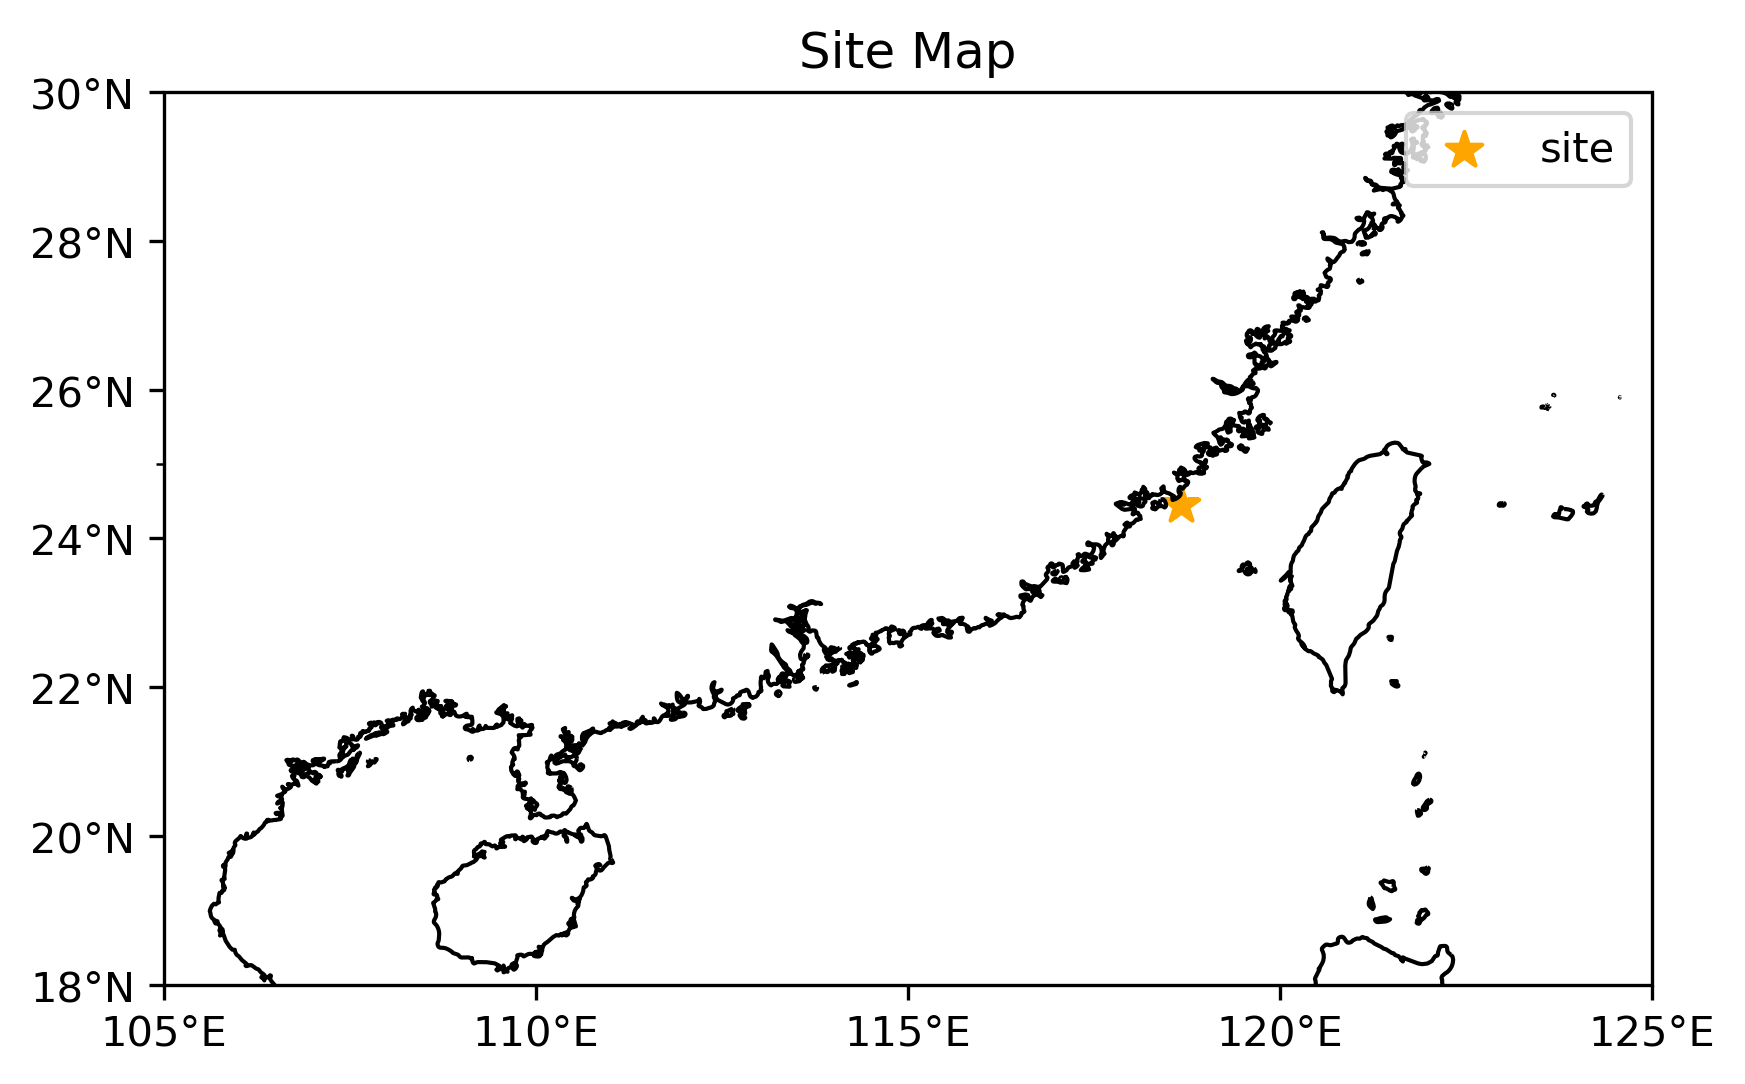

In [11]:
# 站点位置
plt.figure(dpi=300)
ax=plt.axes(facecolor='white', projection=ccrs.PlateCarree(central_longitude=0))
ax.set_title('Site Map')
ax.set_xlim(105,125)
ax.set_ylim(18,30)
ax.scatter(118+40/60,24+27/60,c='Orange',marker='*',s=80,label='site')
ax.legend()
ax.set_xticks(np.arange(105,126,5))
ax.set_yticks(np.arange(18,31,2))
ax.xaxis.set_major_formatter(LongitudeFormatter())#刻度格式转换为经纬度样式 
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.xaxis.set_minor_locator(mticker.MultipleLocator(5))#刻度格式转换为经纬度样式 
ax.yaxis.set_minor_locator(mticker.MultipleLocator(5))
ax.coastlines()
plt.show()
del ax